In [ ]:
!unzip compressed.zip
%ls

Archive:  compressed.zip
   creating: data/
   creating: data/freeFall/
  inflating: data/freeFall/freeFall9.csv  
  inflating: data/freeFall/freeFall8.csv  
  inflating: data/freeFall/freeFall3.csv  
  inflating: data/freeFall/freeFall2.csv  
  inflating: data/freeFall/freeFall1.csv  
  inflating: data/freeFall/freeFall5.csv  
  inflating: data/freeFall/freeFall4.csv  
  inflating: data/freeFall/freefall6.csv  
  inflating: data/freeFall/freeFall7.csv  
  inflating: data/freeFall/freeFall12.csv  
  inflating: data/freeFall/freeFall13.csv  
  inflating: data/freeFall/freeFall11.csv  
  inflating: data/freeFall/freeFall10.csv  
  inflating: data/freeFall/freefall14.csv  
  inflating: data/freeFall/freeFall15.csv  
   creating: data/runSit/
  inflating: data/runSit/runSit3.csv  
  inflating: data/runSit/runSit2.csv  
  inflating: data/runSit/runsit1.csv  
  inflating: data/runSit/runSit5.csv  
  inflating: data/runSit/runSit4.csv  
  inflating: data/runSit/runSit6.csv  
  inflating: data

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import sklearn.model_selection
import os
import xgboost as xgb
from IPython.display import display

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

os.makedirs('./data_normalized', exist_ok=True)


def normalize_data_timestamps():
    labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
    for l in labels:
        i = 0
        for csv_file in glob.glob('data/' + l + '/*.csv'):
            single_df = pd.read_csv(csv_file, sep=';')
            single_df['DiffTimestamp'] = single_df['Timestamp'] - single_df['Timestamp'][0]
            single_df['Series'] = int(''.join(filter(str.isdigit, csv_file)))
            # single_df['Series'] = l + int(''.join(filter(str.isdigit, csv_file)))
            single_df['Label'] = l
            if i == 0:
                df = single_df
            else:
                df = pd.concat([df, single_df], ignore_index=True)

            i += 1
        df[['Label', 'Series', 'DiffTimestamp', 'DeviceOrientation', 'AccelerationX', 'AccelerationY',
            'AccelerationZ']].to_csv(
            './data_normalized/' + l + '.csv', index=False)


def normalize_data():
    """
    Normalize the data by reading all csv files in the given directory and saving the normalized data to csv files.

    Parameters:
    ----------
    None

    Returns:
    -------
    None
    """
    labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
    for l in labels:
        # read all csv files in the directory '/kaggle_data/' + l, delimit by ';'
        df = pd.concat([pd.read_csv(f, sep=';') for f in glob.glob('data/' + l + '/*.csv')], ignore_index=True)
        # assign l to to df column 'Label'
        df['Label'] = l
        df
        # save columns 'DeviceOrientation', 'AccelerationX','AccelerationY', 'AccelerationZ', 'Label' to csv
        df[['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']].to_csv(
            './data_normalized/' + l + '.csv', index=False)


def read_data(fft):
    df = pd.concat([pd.read_csv(f) for f in glob.glob('./data_normalized/*.csv')], ignore_index=True)
    columns = ['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']
    if fft:
        for c in ['AccelerationX', 'AccelerationY', 'AccelerationZ']:
            df[c + '_fft'] = np.abs(np.fft.fft(df[c]))

    return df


def plot_dataset(df, series=1):
    for l in labels:
        plt.figure()
        t = df.loc[df['Label'] == l].loc[df['Series'] == 1]['DiffTimestamp']
        X = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationX']
        Y = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationY']
        Z = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationZ']
        plt.plot(t, X, linewidth=2, label='AccelerationX')
        plt.plot(t, Y, linewidth=2, label='AccelerationY')
        plt.plot(t, Z, linewidth=2, label='AccelerationZ')
        #plt.plot(t, np.sqrt(X ** 2 + Y ** 2 + Z ** 2), linewidth=2, label='Net acceleration')
        plt.legend()
        plt.xlabel('Timestamp (s)')
        plt.ylabel('Acceleration')
        plt.savefig('plots/' + l + 'series_' + str(series) + '_Acceleration.png')


def plot_dataset_fft(df, series=1):
    for l in labels:
        plt.figure()

        X = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationX_fft']
        Y = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationY_fft']
        Z = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationZ_fft']
        plt.plot(X, linewidth=2, label='FFT AccelerationX')
        plt.plot(Y, linewidth=2, label='FFT AccelerationY')
        plt.plot(Z, linewidth=2, label='FFT AccelerationZ')
        # plt.plot(np.sqrt(X ** 2 + Y ** 2 + Z ** 2), linewidth=2, label='Net FFT acceleration')
        plt.legend()
        plt.ylabel('Acceleration')
        plt.savefig('plots/' + l + 'series_' + str(series) + '_Acceleration_fft.png')


def convert_categorical_to_numerical(df):
    df_new = df
    # convert categorical data to numerical data
    df_new['Label'] = df_new['Label'].astype('category')
    df_new['Label'] = df_new['Label'].cat.codes
    # df.head()

    # convert column `DeviceOrientation` to numerical data
    df_new['DeviceOrientation'] = df_new['DeviceOrientation'].astype('category')
    df_new['DeviceOrientation'] = df_new['DeviceOrientation'].cat.codes
    df_new.head()
    return df_new


def split_data(df):
    df_train = df[~df['Series'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
    df_test = df[df['Series'].isin([1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11])]
    print(f'Training size in percent: {len(df_train) / len(df) * 100}')
    print(f'Testing size in percent: {len(df_test)/len(df) * 100}')
    x_train = df_train.drop(labels=['Label'], axis=1)
    y_train =df_train["Label"]
    x_test =df_test.drop(labels=['Label'], axis=1)
    y_test = df_test["Label"]

    #x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=1-split)
    return x_train, x_test, y_train, y_test


def train_model(x_train, y_train, x_test, y_test):

    from tensorflow import keras
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM

    # build a neural network that uses the fft of the accelerometer data to predict the label
    model = Sequential()
    # flatten the input data to a 1D array
    # model.add(Flatten(input_shape=(x.shape[1],)))
    #model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
    #model.add(LSTM(256, activation='relu', return_sequences=True))
    #model.add(LSTM(256, activation='relu'))
    #model.add(Dense(len(labels), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=100, batch_size=64)

    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy:', test_acc)
    #https://arxiv.org/abs/1611.06455

    return


def make_model(input_shape):
    from tensorflow import keras
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(len(labels), activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# normalize_data_timestamps()
labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']

dataset = read_data(fft=True)
plot_dataset(df=dataset, series=1)
# plot_dataset_fft(df=dataset, series=1)

train_dataset = convert_categorical_to_numerical(df=dataset)
display(train_dataset)
train_dataset[:10].to_csv('dataframe.csv', index=False)

# x_train, x_test, y_train, y_test = split_data(df=train_dataset)

# #train_model(x_train, y_train, x_test, y_test)
# xgb_classifier = xgb.XGBClassifier(eta=0.05, max_depth=15, n_estimators=100)
# xgb_classifier.fit(x_train, y_train)
# xgb.plot_importance(xgb_classifier)
# plt.show()
# train_XG = (xgb_classifier.score(x_train, y_train))
# test_XG = (xgb_classifier.score(x_test, y_test))
# print(train_XG, test_XG)

ValueError: ignored

In [ ]:
def create_sequences(data, sequence_length, target_column_index):
    X, y = [], []
    for i in range(len(data)/sequence_length):
        sequence = data[i*sequence_length:(i+1)*sequence_length]
        target = data[i*sequence_length, target_column_index]
        X.append(sequence)
        y.append(target)
    return np.array(X), np.array(y)

# sequence_length = 5  # for example, 5 time steps
sequence_length = 5
target_column_index = df.columns.get_loc('target_column')
X, y = create_sequences(df_scaled, sequence_length, target_column_index)

SyntaxError: ignored

In [ ]:
! pip uninstall tensorflow
! pip install tensorflow==2.14.0

! pip uninstall keras-tuner
! pip install keras-tuner

Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.14.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.14.0
  Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (489.8 MB)
Found existing installation: keras-tuner 1.4.6
Uninstalling keras-tuner-1.4.6:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras_tuner-1.4.6.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras_tuner/*
Proceed (Y/n)? Y
  Successfully uninstalled keras-tuner-1.4.6
  Using cached keras_tuner-1.4.6-py3-no

In [ ]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import sklearn.model_selection
import os
import xgboost as xgb
import time
from IPython.display import display

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

os.makedirs('./data_normalized', exist_ok=True)


def normalize_data_timestamps():
    labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
    for l in labels:
        i = 0
        for csv_file in glob.glob('data/' + l + '/*.csv'):
            single_df = pd.read_csv(csv_file, sep=';')
            single_df['DiffTimestamp'] = single_df['Timestamp'] - single_df['Timestamp'][0]
            single_df['Series'] = int(''.join(filter(str.isdigit, csv_file)))
            single_df['Label'] = l
            if i == 0:
                df = single_df
            else:
                df = pd.concat([df, single_df], ignore_index=True)

            i += 1
        df[['Label', 'Series', 'DiffTimestamp', 'DeviceOrientation', 'AccelerationX', 'AccelerationY',
            'AccelerationZ']].to_csv(
            './data_normalized/' + l + '.csv', index=False)


def normalize_data():
    """
    Normalize the data by reading all csv files in the given directory and saving the normalized data to csv files.

    Parameters:
    ----------
    None

    Returns:
    -------
    None
    """
    labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
    for l in labels:
        # read all csv files in the directory '/kaggle_data/' + l, delimit by ';'
        df = pd.concat([pd.read_csv(f, sep=';') for f in glob.glob('data/' + l + '/*.csv')], ignore_index=True)
        # assign l to to df column 'Label'
        df['Label'] = l
        df
        # save columns 'DeviceOrientation', 'AccelerationX','AccelerationY', 'AccelerationZ', 'Label' to csv
        df[['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']].to_csv(
            './data_normalized/' + l + '.csv', index=False)


def read_data(fft):
    df = pd.concat([pd.read_csv(f) for f in glob.glob('./data_normalized/*.csv')], ignore_index=True)
    columns = ['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']
    if fft:
        for c in ['AccelerationX', 'AccelerationY', 'AccelerationZ']:
            df[c + '_fft'] = np.abs(np.fft.fft(df[c]))

    return df


def plot_dataset(df, series=1):
    for l in labels:
        plt.figure()
        t = df.loc[df['Label'] == l].loc[df['Series'] == 1]['DiffTimestamp']
        X = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationX']
        Y = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationY']
        Z = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationZ']
        plt.plot(t, X, linewidth=2, label='AccelerationX')
        plt.plot(t, Y, linewidth=2, label='AccelerationY')
        plt.plot(t, Z, linewidth=2, label='AccelerationZ')
        #plt.plot(t, np.sqrt(X ** 2 + Y ** 2 + Z ** 2), linewidth=2, label='Net acceleration')
        plt.legend()
        plt.xlabel('Timestamp (s)')
        plt.ylabel('Acceleration')
        plt.savefig('plots/' + l + 'series_' + str(series) + '_Acceleration.png')


def plot_dataset_fft(df, series=1):
    for l in labels:
        plt.figure()

        X = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationX_fft']
        Y = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationY_fft']
        Z = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationZ_fft']
        plt.plot(X, linewidth=2, label='FFT AccelerationX')
        plt.plot(Y, linewidth=2, label='FFT AccelerationY')
        plt.plot(Z, linewidth=2, label='FFT AccelerationZ')
        # plt.plot(np.sqrt(X ** 2 + Y ** 2 + Z ** 2), linewidth=2, label='Net FFT acceleration')
        plt.legend()
        plt.ylabel('Acceleration')
        plt.savefig('plots/' + l + 'series_' + str(series) + '_Acceleration_fft.png')


def convert_categorical_to_numerical(df):
    df_new = df
    # convert categorical data to numerical data
    df_new['Label'] = df_new['Label'].astype('category')
    df_new['Label'] = df_new['Label'].cat.codes
    # df.head()

    # convert column `DeviceOrientation` to numerical data
    df_new['DeviceOrientation'] = df_new['DeviceOrientation'].astype('category')
    df_new['DeviceOrientation'] = df_new['DeviceOrientation'].cat.codes
    df_new.head()
    return df_new


def split_data(df):
    df_train = df[~df['Series'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
    df_test = df[df['Series'].isin([1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11])]
    print(f'Training size in percent: {len(df_train) / len(df) * 100}')
    print(f'Testing size in percent: {len(df_test)/len(df) * 100}')
    x_train = df_train.drop(labels=['Label'], axis=1)
    y_train =df_train["Label"]
    x_test =df_test.drop(labels=['Label'], axis=1)
    y_test = df_test["Label"]

    #x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=1-split)
    return x_train, x_test, y_train, y_test


def train_model(x_train, y_train, x_test, y_test):
    from tensorflow import keras
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM
    from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout


    model = Sequential()
    # Assuming x_train.shape = (num_samples, sequence_length, num_features)






    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    # LSTM layer for understanding sequence
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    # Flatten and output
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    """
    model.add(LSTM(256, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True))
    model.add(LSTM(16, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True))
    model.add(LSTM(64, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True))
    model.add(LSTM(256, dropout=0.05, recurrent_dropout=0.01, activation='tanh'))
    model.add(Dense(len(labels), activation='softmax'))



    # First, add convolutional layers for feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Next, add LSTM layers for sequence processing
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels), activation='softmax'))



    model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(128, dropout=0.05, activation='tanh', return_sequences=True))
    model.add(LSTM(64,  activation='tanh', return_sequences=True))
    model.add(LSTM(128, dropout=0.05, activation='tanh', return_sequences=True))
    model.add(LSTM(256,  activation='tanh'))


    model.add(LSTM(256, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(256, dropout=0.1, recurrent_dropout=0.1, activation='tanh'))
    model.add(Dense(len(labels), activation='softmax'))

    model.add(Dense(512,  activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(128,  activation='relu'))
    model.add(Dense(32,  activation='relu'))
    model.add(Dense(128,  activation='relu'))
    model.add(Dense(512,  activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    """

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train,
                        y_train,
                        epochs=100,
                        batch_size=64,
                        validation_data=(x_test, y_test))

    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy:', test_acc)
    return history


from kerastuner.tuners import BayesianOptimization

def build_model(hp):
    from tensorflow import keras
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM
    model = Sequential()

    model.add(LSTM(units=hp.Choice('units1', values=[16, 32, 64, 128, 256, 512]), activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Choice('units2', values=[16, 32, 64, 128, 256, 512]),  activation='tanh', return_sequences=True))
    model.add(LSTM(units=hp.Choice('units3', values=[16, 32, 64, 128, 256, 512]),  activation='tanh', return_sequences=True))
    model.add(LSTM(units=hp.Choice('units2', values=[16, 32, 64, 128, 256, 512]),  activation='tanh', return_sequences=True))
    model.add(LSTM(units=hp.Choice('units1', values=[16, 32, 64, 128, 256, 512]),  activation='tanh'))
    model.add(Dense(len(labels), activation='softmax'))

    #model.compile(optimizer='adam',
    #              loss='sparse_categorical_crossentropy',
    #              metrics=['accuracy'])


    model.compile(optimizer=tf.keras.optimizers.Adam(
              hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model


    #https://arxiv.org/abs/1611.06455
def create_sequences(data, sequence_length, target_column_index):
    X, y = [], []
    series_values = np.sort(data['Series'].unique())
    sequence_lengths = []
    for series_value in series_values:
        data_sequence = data[data['Series'].isin([series_value])]
        label_values = np.sort(data_sequence['Label'].unique())
        for label_value in label_values:
            data_sequence_label = data_sequence[data_sequence['Label'].isin([label_value])]
            sequence_lengths.append(len(data_sequence_label))
            #print(series_value)
            #print(sequence_length)
            X.append(data_sequence_label[['DiffTimestamp', 'DeviceOrientation',
           'AccelerationX', 'AccelerationY', 'AccelerationZ']][-145:])
            y.append(data_sequence_label['Label'].unique())


    n = 5
    return np.array(X), np.array(y), n


labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
dataset = read_data(fft=True)
train_dataset = convert_categorical_to_numerical(df=dataset)

train_dataset[:10].to_csv('dataframe.csv', index=False)

sequence_length = 5
target_column_index = train_dataset.columns.get_loc('Label')

X, y, n_features = create_sequences(train_dataset, sequence_length, target_column_index)

np.random.seed(42)
# Generate a permutation of indices and apply it to both arrays
permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# Start time
start_time = time.time()

tuner = BayesianOptimization(build_model,
                             objective='val_accuracy',
                             max_trials=10,
                             executions_per_trial=2,
                             directory='lstm_autoencoder2_alldata',
                             project_name='bayesian_optim')

tuner.search(X, y,
             epochs=10,
             validation_data=(X_test, y_test))

# history = train_model(X_train, y_train, X_test, y_test)

# End time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time

KeyError: ignored

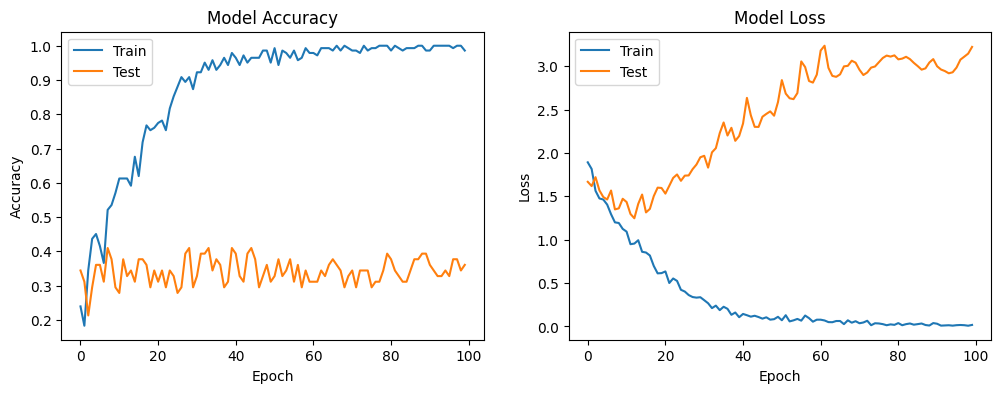

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Training size in percent: 68.72343891134705
Testing size in percent: 31.276561088652954


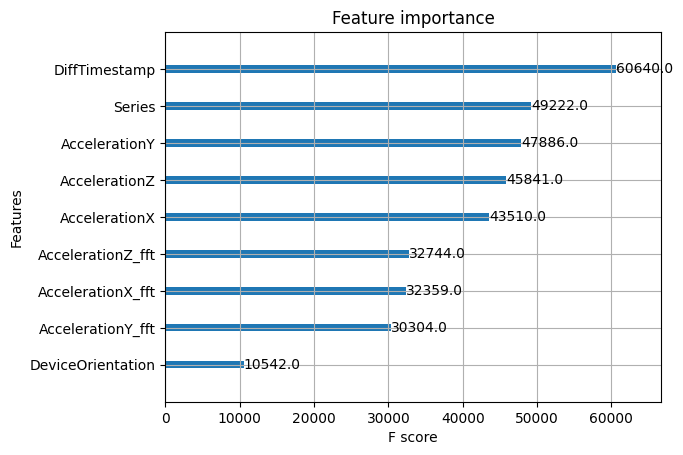

0.9859587885055985 0.5769971277972414
The algorithm took 54.70737648010254 seconds to complete.


In [ ]:
import time

# Start time
start_time = time.time()


x_train, x_test, y_train, y_test = split_data(df=train_dataset)

#train_model(x_train, y_train, x_test, y_test)
xgb_classifier =  xgb.XGBClassifier(eta=0.05, max_depth=15, n_estimators=100)
xgb_classifier.fit(x_train, y_train)
xgb.plot_importance(xgb_classifier)
plt.show()
train_XG = (xgb_classifier.score(x_train, y_train))
test_XG = (xgb_classifier.score(x_test, y_test))

predictions = xgb_classifier.predict(x_test)
ssr = ((predictions - y_test)**2).sum()

print(train_XG, test_XG)

# End time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"The algorithm took {elapsed_time} seconds to complete.")


In [ ]:
np.unique(np.array(train_dataset['Series'])).shape

(48,)

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
# And it has columns 'Series', 'Timestamp', and other data columns

# Group by 'Series' and calculate duration and count
df = train_dataset.copy()

# df['DiffTimestamp'] = pd.to_datetime(train_dataset['DiffTimestamp'])

grouped = df.groupby('Series').agg(Duration=('DiffTimestamp', lambda x: x.max() - x.min()),
                                    Count=('DiffTimestamp', 'count'))

# Find the shortest sequence by duration and count
shortest_by_duration = grouped['Duration'].idxmin()
shortest_by_count = grouped['Count'].idxmin()

# Get details of the shortest sequence by duration
shortest_duration_series = grouped.loc[shortest_by_duration]
duration_details = (shortest_by_duration, shortest_duration_series['Duration'], shortest_duration_series['Count'])

# Get details of the shortest sequence by count
shortest_count_series = grouped.loc[shortest_by_count]
count_details = (shortest_by_count, shortest_count_series['Duration'], shortest_count_series['Count'])

# Print results
print(f"Shortest by duration: Series Label = {duration_details[0]}, Duration = {duration_details[1]}, Number of Points = {duration_details[2]}")
print(f"Shortest by count: Series Label = {count_details[0]}, Duration = {count_details[1]}, Number of Points = {count_details[2]}")

Shortest by duration: Series Label = 31, Duration = 33.7424099445343, Number of Points = 3261.0
Shortest by count: Series Label = 48, Duration = 38.58872103691101, Number of Points = 972.0


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, y_test are your data

# Make predictions on the test data
xgb_predictions = xgb_classifier.predict(x_test)

# Calculate the accuracy
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"Accuracy: {xgb_accuracy}")

Accuracy: 0.594403939020926


In [ ]:
xgb_predictions.shape

(63366,)

In [ ]:
# XGBoost
# Create regression matrices

"""
learning_rate_range = np.arange(0.01, 1, 0.05)
depth_range = np.arange(10, 100, 10)

for maxdepth in depth_range:
    test_XG = []
    train_XG = []
    for lr in learning_rate_range:

        xgb_classifier = xgb.XGBClassifier(eta = lr, max_depth = maxdepth)
        xgb_classifier.fit(x_train, y_train)
        train_XG.append(xgb_classifier.score(x_train, y_train))
        test_XG.append(xgb_classifier.score(x_test, y_test))

    fig = plt.figure(figsize=(10, 7))
    plt.plot(learning_rate_range, train_XG, c='orange', label=f'Train, Depth = {maxdepth}')
    plt.plot(learning_rate_range, test_XG, c='m', label='Test, Depth = {maxdepth}')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()
"""


In [ ]:
import time

# Start time
start_time = time.time()

model = make_model(input_shape=(x_train.shape[1], 1))

epochs = 100
batch_size = 32
import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

# End time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"The algorithm took {elapsed_time} seconds to complete.")


#TODO: Sequencing, only use whole sequences, and not single samples - for splitting, training and testing

Epoch 1/100
3481/3481 [==============================] - 38s 8ms/step - loss: 0.8648 - sparse_categorical_accuracy: 0.5953 - val_loss: 10.3142 - val_sparse_categorical_accuracy: 0.1297 - lr: 0.0010
Epoch 2/100
  17/3481 [..............................] - ETA: 23s - loss: 0.7458 - sparse_categorical_accuracy: 0.6654

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3481/3481 [==============================] - 26s 7ms/step - loss: 0.7334 - sparse_categorical_accuracy: 0.6749 - val_loss: 13.5755 - val_sparse_categorical_accuracy: 0.1360 - lr: 0.0010
Epoch 3/100
3481/3481 [==============================] - 28s 8ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7315 - val_loss: 14.8490 - val_sparse_categorical_accuracy: 0.0683 - lr: 0.0010
Epoch 4/100
3481/3481 [==============================] - 26s 8ms/step - loss: 0.5642 - sparse_categorical_accuracy: 0.7651 - val_loss: 20.8429 - val_sparse_categorical_accuracy: 1.4364e-04 - lr: 0.0010
Epoch 5/100
3481/3481 [==============================] - 27s 8ms/step - loss: 0.5082 - sparse_categorical_accuracy: 0.7942 - val_loss: 21.4142 - val_sparse_categorical_accuracy: 0.0014 - lr: 0.0010
Epoch 6/100
3481/3481 [==============================] - 26s 7ms/step - loss: 0.4681 - sparse_categorical_accuracy: 0.8107 - val_loss: 25.4810 - val_sparse_categorical_accuracy: 0.0148 - lr: 0.0010
Epoch 7/100
3481/3

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, y_test are your data

# Make predictions on the test data
predictions = model.predict(x_test)

1981/1981 [==============================] - 7s 3ms/step


ValueError: ignored

In [ ]:
model.save_weights('dense_layer_weights.h5')

In [ ]:
class_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
dnn_accuracy = accuracy_score(y_test, class_labels)
print(f"Dense Layer Accuracy: {dnn_accuracy}")

Dense Layer Accuracy: 0.21091752674936085


In [ ]:
y_test.shape

(63366,)